In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader,Dataset, random_split
from PIL import Image
import random

seed = 2302
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# inception_pet

In [3]:
class plot():
    def __init__(self, file="./result/inception_pet.txt", title='inceptionV3 with OxfordIIITPet dataset'):
        self.file = file
        self.title = title

        self.scores = np.loadtxt(self.file)
        self.scores_drop0, self.scores_0 = [],[]
        self.scores_drop0_idx, self.scores_0_idx = [], []

        for i in range(len(self.scores)):
            if self.scores[i] == 0:
                self.scores_0.append(self.scores[i])
                self.scores_0_idx.append(i)
            else:
                self.scores_drop0.append(self.scores[i])
                self.scores_drop0_idx.append(i)

        self.scores_drop0, self.scores_0 = np.array(self.scores_drop0), np.array(self.scores_0)
        self.scores_drop0_idx, self.scores_0_idx = np.array(self.scores_drop0_idx), np.array(self.scores_0_idx)
        # scores_0 = np.array([score for score in scores if score == 0])
        # scores = np.array([score for score in scores if score != 0]) #drop out values of 0 
        self.mean = np.mean(self.scores_drop0)
        self.std = np.std(self.scores_drop0)

    def plot_graph(self):
        plt.hist(self.scores_drop0, bins=30, color='c', edgecolor='black', alpha=0.7)
        plt.axvline(self.mean, color='r', linestyle='dashed', linewidth=1, label='Mean')
        # plt.axvline(mean_baseline + std_baseline, color='b', linestyle='dashed', linewidth=1, label='Mean + 1SD')
        # plt.axvline(mean_baseline - std_baseline, color='b', linestyle='dashed', linewidth=1, label='Mean - 1SD')
        plt.title(self.title)
        plt.xlabel('Rarity Score')
        plt.ylabel('Frequency')
        plt.legend(loc='upper right')
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

    def plot_table(self):
        #summary table
        df = pd.read_csv(self.file,names=["rarity score"])
        print(df.describe()) # table with 0 scores
        print(df[df["rarity score"]!=0].describe()) # table without 0 scores

    def display_images_grid(self, dataset, indices, title):
        plt.figure(figsize=(6, 3))
        for i, idx in enumerate(indices):
            image, _ = dataset[idx]
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()

            plt.subplot(2, 5, i + 1)
            plt.imshow(image)
            plt.title(f'Image {idx + 1}')
            plt.axis('off')
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    def display_image(self, dataset):
        sorted_scores_idx = np.argsort(self.scores_drop0)
        sorted_indices = self.scores_drop0_idx[sorted_scores_idx]

        # Lowest 10 scores
        lowest_10_indices = sorted_indices[:10]

        # Highest 10 scores
        highest_10_indices = sorted_indices[-10:]

        # Display images for the lowest 10 scores
        self.display_images_grid(dataset, lowest_10_indices, "10 Images with the Lowest Scores")

        # Display images for the highest 10 scores
        self.display_images_grid(dataset, highest_10_indices, "10 Images with the Highest Scores")



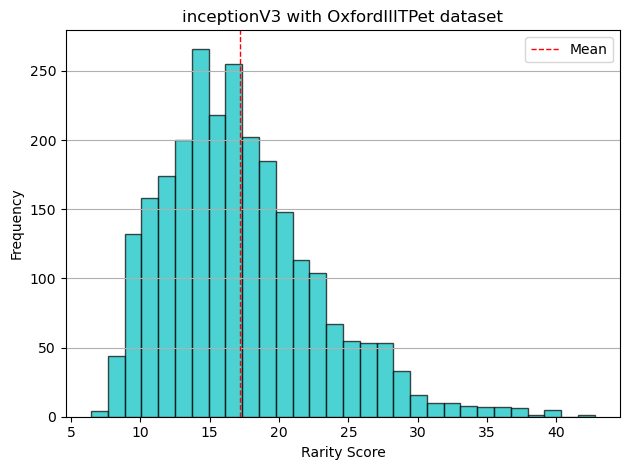

       rarity score
count   3669.000000
mean      11.893986
std        9.200498
min        0.000000
25%        0.000000
50%       13.668156
75%       18.172887
max       42.769030
       rarity score
count   2535.000000
mean      17.214609
std        5.558978
min        6.445198
25%       13.217317
50%       16.357587
75%       20.155100
max       42.769030


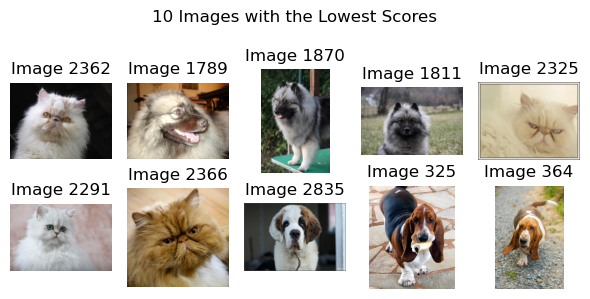

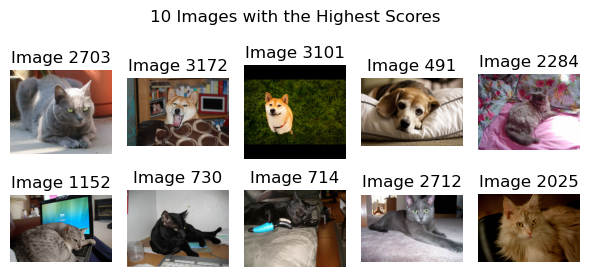

In [3]:
transform = transforms.Compose([
    # transforms.Resize((299, 299)),
    transforms.ToTensor()
])
dataset = datasets.OxfordIIITPet(root="./oxford_pet_data/", split="test", download=False, transform=transform)

inception_pet = plot(file="./result/inception_pet.txt", title='inceptionV3 with OxfordIIITPet dataset')
inception_pet.plot_graph()
inception_pet.plot_table()
inception_pet.display_image(dataset)



# inception widerface

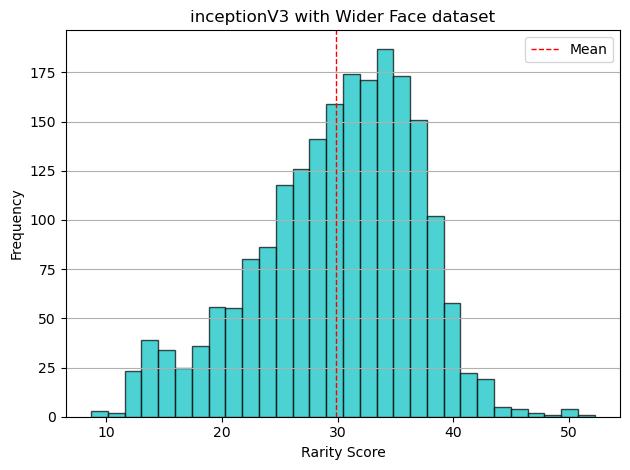

       rarity score
count   3226.000000
mean      19.055592
std       15.409641
min        0.000000
25%        0.000000
50%       24.732322
75%       32.558191
max       52.223014
       rarity score
count   2057.000000
mean      29.884948
std        6.976972
min        8.676028
25%       25.605035
50%       30.786917
75%       35.040227
max       52.223014


In [4]:
class WiderFaceDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.annotations = self.load_annotations(annotation_file)
        self.images = [annotation['image'] for annotation in self.annotations]

    def load_annotations(self, annotation_file):
        annotations = []
        with open(annotation_file, 'r') as file:
            lines = file.readlines()
            i = 0
            while i < len(lines):
                # read the image filename
                image_path = lines[i].strip()
                i += 1

                # the number of faces
                num_faces = int(lines[i].strip())
                i += 1  # Move to the first bounding box line or skip if num_faces is 0

                # if no faces, skip this image
                if num_faces == 0:
                    i += 1
                    continue

                boxes = []
                for _ in range(num_faces):
                    box_info = lines[i].strip().split()
                    # Extract the first four values (x, y, width, height)
                    x, y, w, h = [int(box_info[k]) for k in range(4)]
                    boxes.append([x, y, x + w, y + h])
                    i += 1

                annotations.append({'image': image_path, 'boxes': boxes})

        return annotations



    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.annotations[index]['image'])
        img = Image.open(img_path)

        original_size = img.size

        # corresponding bounding boxes
        bboxes = self.annotations[index]['boxes']

        # apply image transformations()
        if self.transform:
            img = self.transform(img)

        # scale factors
        scale_x = 299 / original_size[0]
        scale_y = 299 / original_size[1]

        # scale the bounding boxes
        scaled_bboxes = []
        for box in bboxes:
            x1, y1, x2, y2 = box
            scaled_bboxes.append([x1 * scale_x, y1 * scale_y, x2 * scale_x, y2 * scale_y])

        # convert scaled bounding boxes(annotations) to a tensor
        scaled_bboxes = torch.tensor(scaled_bboxes, dtype=torch.float32)

        return img, scaled_bboxes

transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

dataset = WiderFaceDataset(image_dir='./widerface_data/widerface/WIDER_val/images/', 
                                 annotation_file='./widerface_data/widerface/wider_face_split/wider_face_val_bbx_gt.txt', 
                                 transform=transform_inception)


inception_widerface = plot(file="./result/inception_widerface.txt", title='inceptionV3 with Wider Face dataset')
inception_widerface.plot_graph()
inception_widerface.plot_table()
inception_widerface.display_image(dataset)

# resnet pet

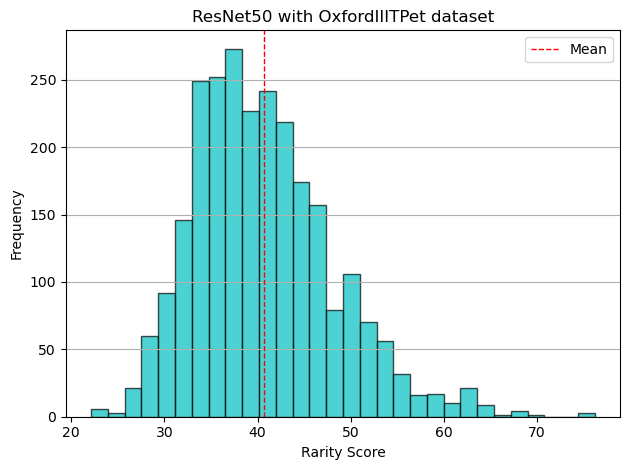

       rarity score
count   3669.000000
mean      28.203564
std       19.750564
min        0.000000
25%        0.000000
50%       35.760938
75%       42.357158
max       76.174941
       rarity score
count   2546.000000
mean      40.643706
std        7.510020
min       22.139784
25%       35.161113
50%       39.679748
75%       44.967339
max       76.174941


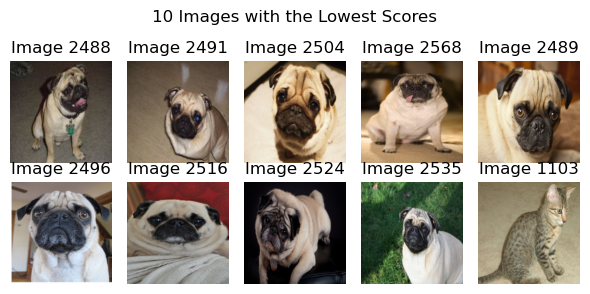

In [5]:
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.OxfordIIITPet(root="./oxford_pet_data/", split="test", download=False, transform=transform_resnet)


resnet_pet = plot(file="./result/resnet_pet.txt", title='ResNet50 with OxfordIIITPet dataset')
resnet_pet.plot_graph()
resnet_pet.plot_table()
resnet_pet.display_image(dataset)

# ResNet50 widerface

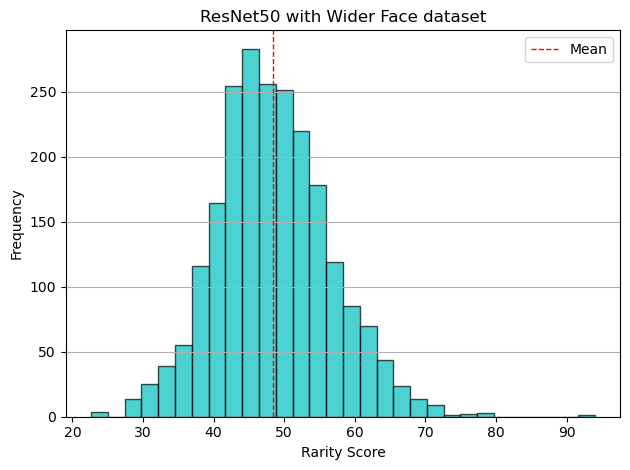

       rarity score
count   3226.000000
mean      33.500818
std       23.365424
min        0.000000
25%        0.000000
50%       43.590594
75%       50.823507
max       93.994181
       rarity score
count   2231.000000
mean      48.441792
std        8.089767
min       22.635001
25%       43.068523
50%       47.819330
75%       53.475542
max       93.994181


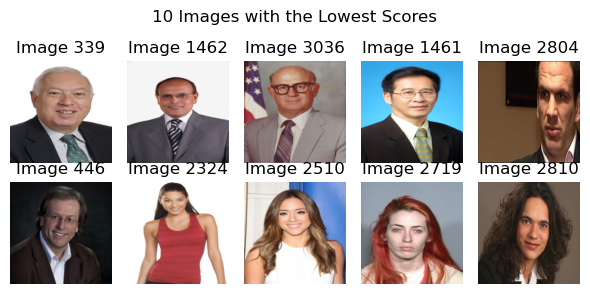

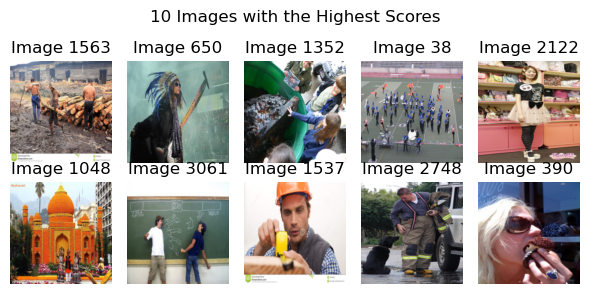

In [6]:
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = WiderFaceDataset(image_dir='./widerface_data/widerface/WIDER_val/images/', 
                                 annotation_file='./widerface_data/widerface/wider_face_split/wider_face_val_bbx_gt.txt', 
                                 transform=transform_resnet)

resnet_widerface = plot(file="./result/resnet_widerface.txt", title='ResNet50 with Wider Face dataset')
resnet_widerface.plot_graph()
resnet_widerface.plot_table()
resnet_widerface.display_image(dataset)

# inceptionV3 celebA (images in result/inception_celeba)

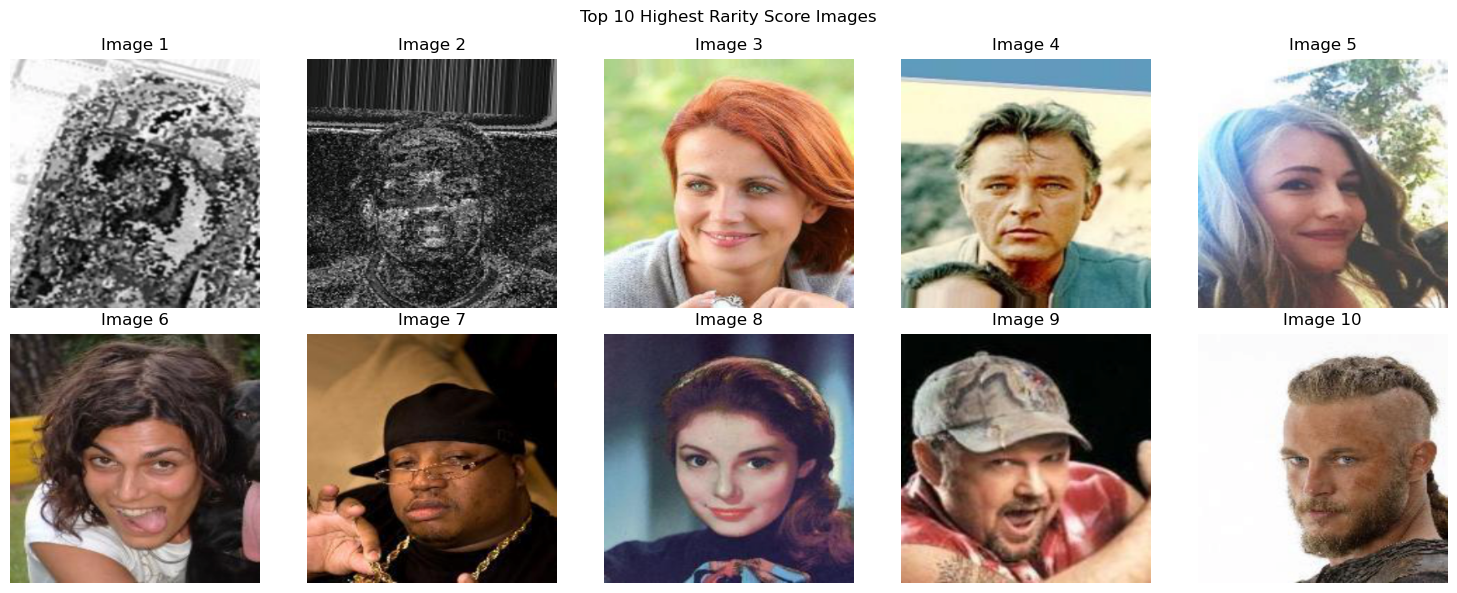

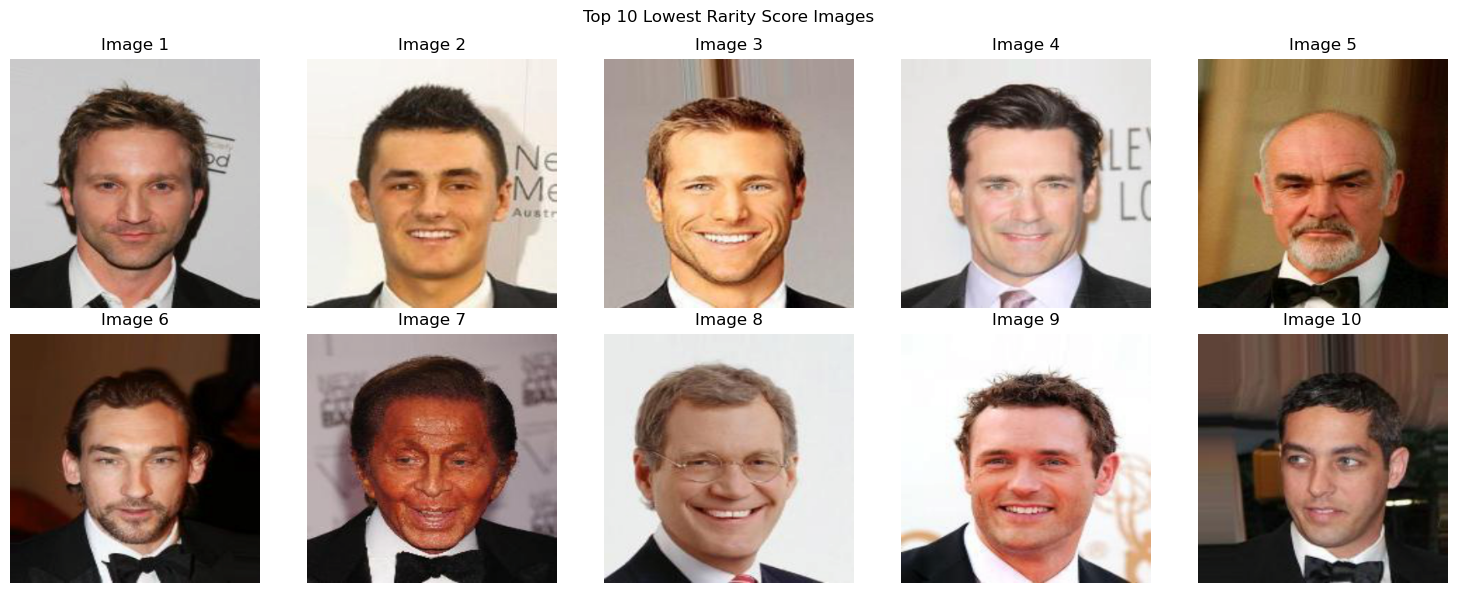

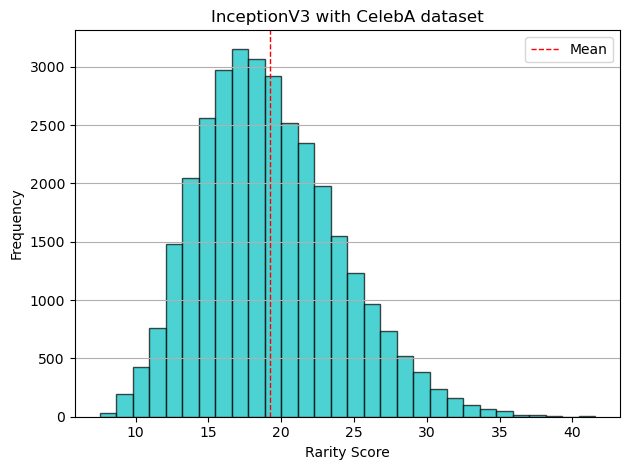

       rarity score
count  48831.000000
mean      12.788966
std        9.861085
min        0.000000
25%        0.000000
50%       15.705326
75%       20.298518
max       41.566554
       rarity score
count  32525.000000
mean      19.200554
std        4.783641
min        7.520943
25%       15.712861
50%       18.694603
75%       22.234097
max       41.566554


In [5]:
transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

def display_images_grid_from_files(image_folder, title, high=True):
    plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
    for i in range(1, 11):
        image_path = os.path.join(image_folder, f'highest_{i}.png' if high else f'lowest_{i}.png')
        image = Image.open(image_path)
        plt.subplot(2, 5, i)
        plt.imshow(image)
        plt.title(f'Image {i}')
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

display_images_grid_from_files("./result/inception_celeba", "Top 10 Highest Rarity Score Images")
display_images_grid_from_files("./result/inception_celeba", "Top 10 Lowest Rarity Score Images", high=False)

# celeba_dataset = datasets.CelebA(root="./celeba_data", split="train", download=False, transform=transform_resnet)
# fake_percentage = 0.3
# fake_size = int(len(celeba_dataset) * fake_percentage)
# real_size = len(celeba_dataset) - fake_size
# _ , fake_dataset_celeba = random_split(celeba_dataset, [real_size, fake_size])

inception_celeba = plot(file="./result/inception_celeba.txt", title='InceptionV3 with CelebA dataset')
inception_celeba.plot_graph()
inception_celeba.plot_table()
# inception_celeba.display_image(fake_dataset_celeba)

# ResNet 50 celebA

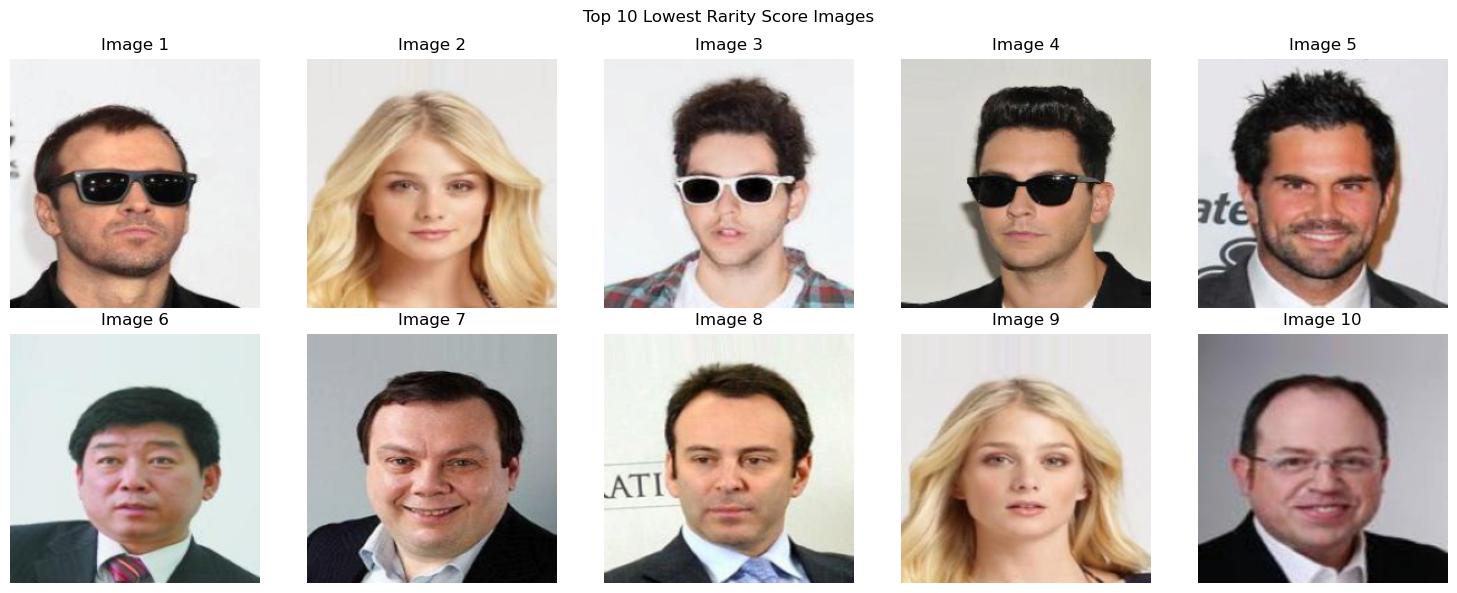

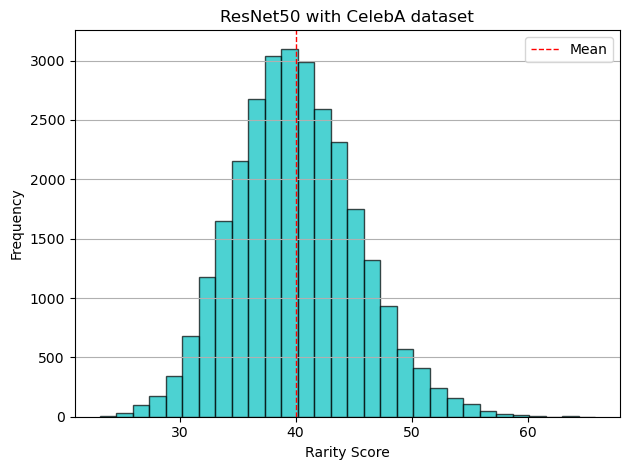

       rarity score
count  48831.000000
mean      23.461663
std       20.139591
min        0.000000
25%        0.000000
50%       34.525438
75%       40.784360
max       65.811549
       rarity score
count  28605.000000
mean      40.050916
std        5.288543
min       23.110709
25%       36.406899
50%       39.819196
75%       43.479177
max       65.811549


In [6]:
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

display_images_grid_from_files("./result/resnet_celeba", "Top 10 Highest Rarity Score Images")
display_images_grid_from_files("./result/resnet_celeba", "Top 10 Lowest Rarity Score Images", high=False)

resnet_celeba = plot(file="./result/resnet_celeba.txt", title='ResNet50 with CelebA dataset')
resnet_celeba.plot_graph()
resnet_celeba.plot_table()

# VGG16 StyleGAN2 with CIFAR10 dataset

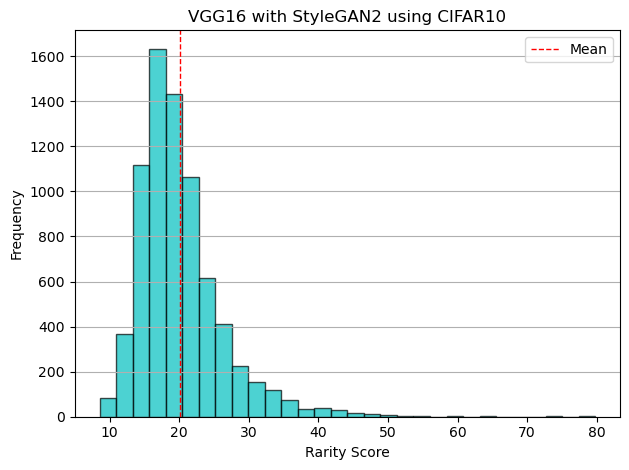

       rarity score
count  10000.000000
mean      14.985972
std       10.226014
min        0.000000
25%        0.000000
50%       16.995917
75%       21.029721
max       79.768504
       rarity score
count   7451.000000
mean      20.112699
std        6.101151
min        8.571863
25%       16.131187
50%       18.852458
75%       22.486491
max       79.768504


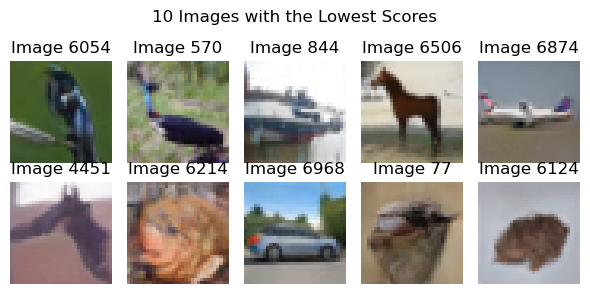

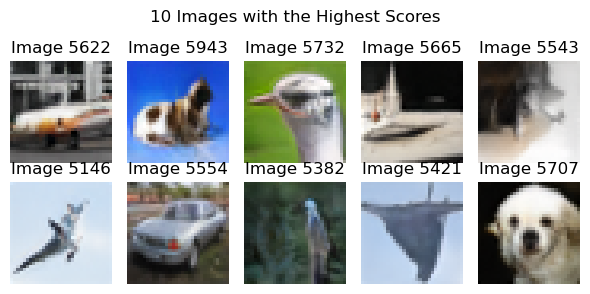

In [9]:
transform_vgg = transforms.Compose([
    transforms.ToTensor(),
])

class ImageDataset(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transform = transform
        self.img_names = os.listdir(path)
        
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self,idx):
        img_path = os.path.join(self.path, self.img_names[idx])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        _ = None
        return image, _


dataset = ImageDataset("./cifar10-stylegan2-imgs/", transform_vgg)

vgg_stylegan = plot(file="./result/vgg_stylegan2.txt", title='VGG16 with StyleGAN2 using CIFAR10')
vgg_stylegan.plot_graph()
vgg_stylegan.plot_table()
vgg_stylegan.display_image(dataset)

# VGG16 BigGAN-deep with CIFAR10 dataset

       rarity score
count  10000.000000
mean      14.712676
std       10.453965
min        0.000000
25%        0.000000
50%       16.819269
75%       21.002873
max       66.819448
       rarity score
count   7290.000000
mean      20.181997
std        6.286492
min        8.052614
25%       16.087531
50%       18.832237
75%       22.731477
max       66.819448


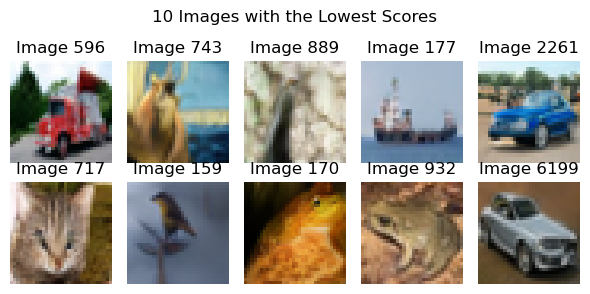

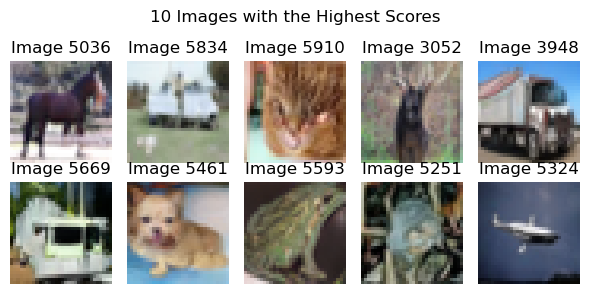

In [10]:
dataset = ImageDataset("./cifar10-biggan-deep-imgs/", transform_vgg)

vgg_biggan = plot(file="./result/vgg_biggan_deep.txt", title='VGG16 with BigGAN-deep using CIFAR10')
vgg_biggan.plot_graph()
vgg_biggan.plot_table()
vgg_biggan.display_image(dataset)

# Inception V3 StyleGAN2 with CIFAR10 dataset

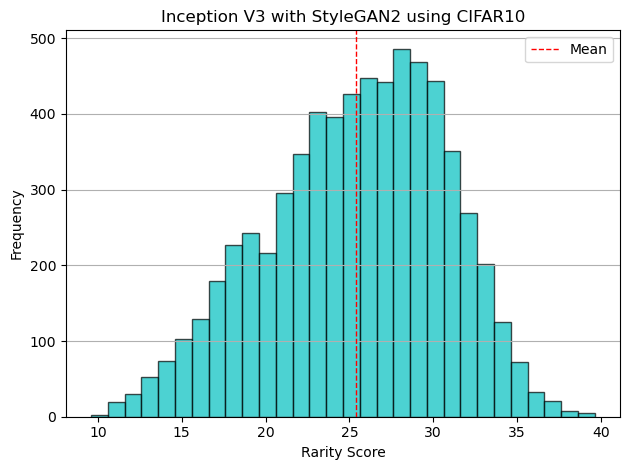

       rarity score
count  10000.000000
mean      16.522394
std       12.830871
min        0.000000
25%        0.000000
50%       21.365040
75%       27.574189
max       39.631506
       rarity score
count   6510.000000
mean      25.380022
std        5.297360
min        9.590737
25%       21.757981
50%       25.848726
75%       29.365456
max       39.631506


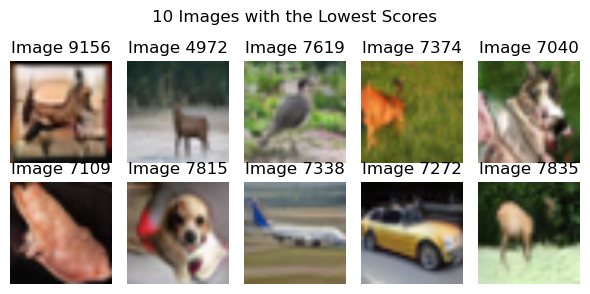

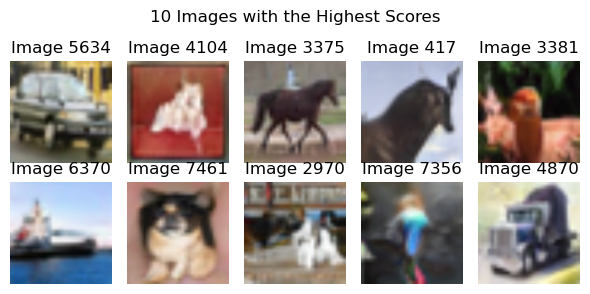

In [11]:
dataset = ImageDataset("./cifar10-stylegan2-imgs/", transform_inception)

inception_stylegan = plot(file="./result/inception_stylegan2.txt", title='Inception V3 with StyleGAN2 using CIFAR10')
inception_stylegan.plot_graph()
inception_stylegan.plot_table()
inception_stylegan.display_image(dataset)

# Inception V3 BigGAN-deep with CIFAR10 dataset

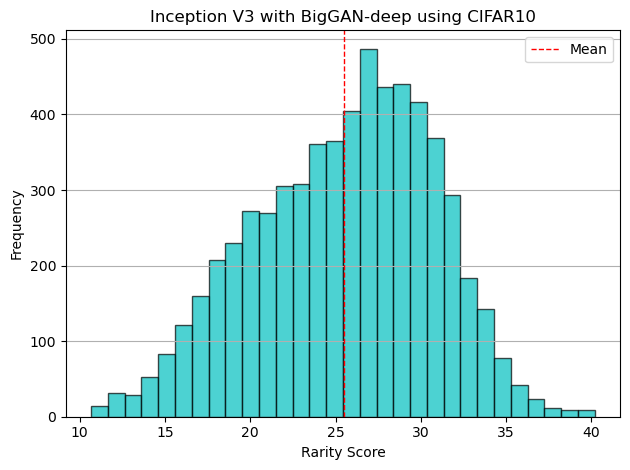

       rarity score
count  10000.000000
mean      15.701669
std       13.076618
min        0.000000
25%        0.000000
50%       20.337233
75%       27.320033
max       40.194810
       rarity score
count   6155.000000
mean      25.510428
std        5.250770
min       10.663647
25%       21.722605
50%       26.067606
75%       29.451500
max       40.194810


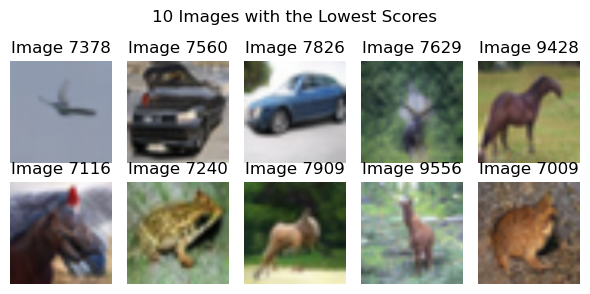

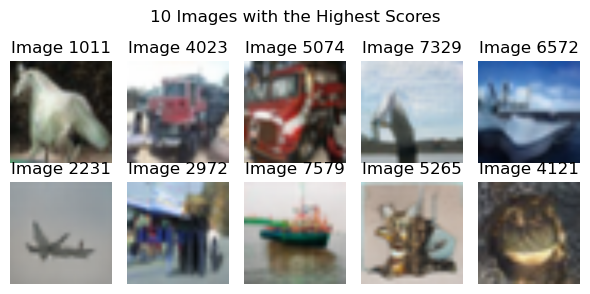

In [12]:
dataset = ImageDataset("./cifar10-biggan-deep-imgs/", transform_inception)

inception_biggan = plot(file="./result/inception_biggan_deep.txt", title='Inception V3 with BigGAN-deep using CIFAR10')
inception_biggan.plot_graph()
inception_biggan.plot_table()
inception_biggan.display_image(dataset)

# ResNet50 StyleGAN2 with CIFAR10 dataset

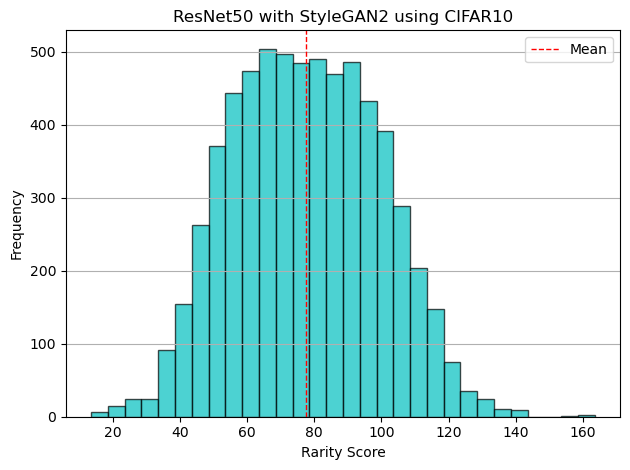

       rarity score
count  10000.000000
mean      49.742957
std       41.051453
min        0.000000
25%        0.000000
50%       58.865500
75%       84.268419
max      163.509448
       rarity score
count   6418.000000
mean      77.505387
std       21.768038
min       13.608504
25%       61.097747
50%       77.317771
75%       93.702939
max      163.509448


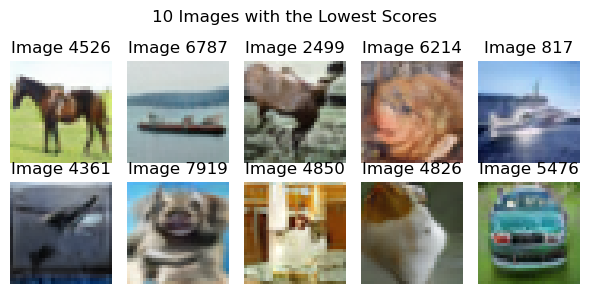

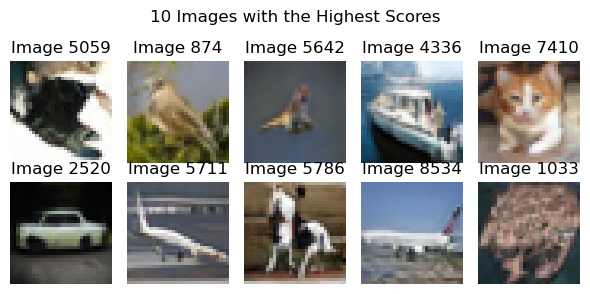

In [13]:
dataset = ImageDataset("./cifar10-stylegan2-imgs/", transform)

resnet_stylegan = plot(file="./result/resnet_stylegan2.txt", title='ResNet50 with StyleGAN2 using CIFAR10')
resnet_stylegan.plot_graph()
resnet_stylegan.plot_table()
resnet_stylegan.display_image(dataset)

# ResNet50 BigGAN-deep with CIFAR10 dataset

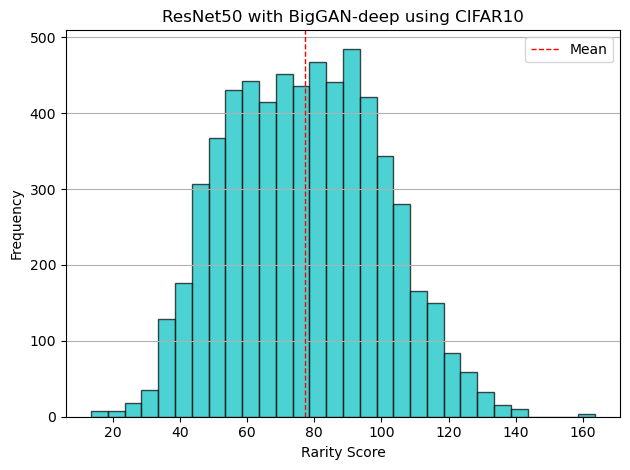

       rarity score
count  10000.000000
mean      47.712892
std       41.516463
min        0.000000
25%        0.000000
50%       55.213809
75%       83.438649
max      163.509448
       rarity score
count   6183.000000
mean      77.167866
std       22.682537
min       13.608504
25%       59.462722
50%       77.224339
75%       93.752090
max      163.509448


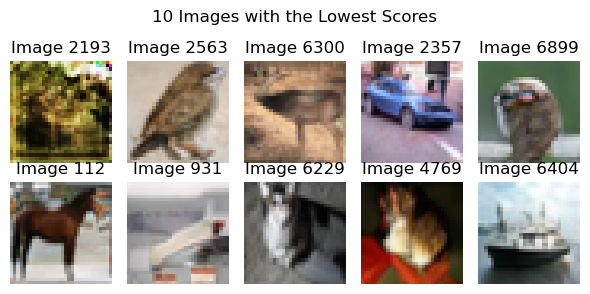

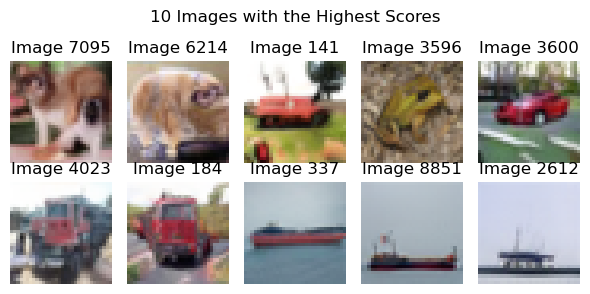

In [14]:
dataset = ImageDataset("./cifar10-biggan-deep-imgs/", transform)

resnet_biggan = plot(file="./result/resnet_biggan_deep.txt", title='ResNet50 with BigGAN-deep using CIFAR10')
resnet_biggan.plot_graph()
resnet_biggan.plot_table()
resnet_biggan.display_image(dataset)